showing all parameters in the input corrected (modified)csv file

In [1]:
import pandas as pd
import numpy as np

# Load AIS messages
data = pd.read_csv('/kaggle/input/2nd-dataset/output_anomalies (1).csv')

# Print column names to ensure correct names
print(data.columns)

# Remove erroneous messages where SOG > 30 knots
data = data[data['SOG'] <= 30]

# Convert BaseDateTime to datetime
data['BaseDateTime'] = pd.to_datetime(data['BaseDateTime'])

# Set BaseDateTime as the index
data.set_index('BaseDateTime', inplace=True)

# Check for duplicate indices and remove them
if data.index.duplicated().any():
    print("Duplicates found in index")
    data = data[~data.index.duplicated(keep='first')]

# Resample to 10-minute intervals and interpolate missing values
data = data.resample('10T').interpolate()

# Split discontiguous voyages
def split_voyages(df, max_gap='2H'):
    df['gap'] = df.index.to_series().diff().shift(-1)
    voyages = []
    for _, group in df.groupby(df['gap'] > pd.Timedelta(max_gap)):
        if not group.empty:
            voyages.append(group)
    return voyages

voyages = split_voyages(data)

# Split very long voyages into smaller tracks
def split_long_voyages(voyages, min_duration='4H', max_duration='24H'):
    split_voyages = []
    for voyage in voyages:
        duration = voyage.index[-1] - voyage.index[0]
        while duration > pd.Timedelta(max_duration):
            split_voyages.append(voyage.iloc[:-(len(voyage) // 2)])
            voyage = voyage.iloc[len(voyage) // 2:]
            duration = voyage.index[-1] - voyage.index[0]
        split_voyages.append(voyage)
    return split_voyages

processed_voyages = split_long_voyages(voyages)


Index(['IMO', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'Status',
       'CurrentData_SOG', 'CurrentData_COG', 'SOG_variation', 'COG_variation',
       'Avg_speed', 'Avg_acceleration', 'Time_diff', 'SpeedChangeRate',
       'KeepPoint', 'Anomaly'],
      dtype='object')
Duplicates found in index


/tmp/ipykernel_36/3498372672.py:25: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data = data.resample('10T').interpolate()
/tmp/ipykernel_36/3498372672.py:25: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.resample('10T').interpolate()
/tmp/ipykernel_36/3498372672.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  for _, group in df.groupby(df['gap'] > pd.Timedelta(max_gap)):
/tmp/ipykernel_36/3498372672.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  while duration > pd.Timedelta(max_duration):


showing basic structure of a simple RNN model


In [2]:
import torch
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Output of the last time step
        return out

input_size = 4  # Example input size
hidden_size = 128
output_size = 1  # Example output size
model = SimpleRNN(input_size, hidden_size, output_size)


Showing structure of my probabilistic RNN model which uses ELBO mechanism to calculate loss function 

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

class ProbabilisticRNN(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, output_size):
        super(ProbabilisticRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc_hidden = nn.Linear(hidden_size, output_size)  # Output from RNN hidden size to output size
        self.fc_latent = nn.Linear(latent_size, output_size)  # Latent size to output size
        self.fc_prior = nn.Linear(hidden_size, latent_size)  # Hidden size to latent size

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)  # Initial hidden state
        out, _ = self.rnn(x, h0)  # RNN forward pass
        out = out[:, -1, :]  # Take the last output of the sequence

        emissions = self.fc_hidden(out)  # Fully connected layer to get emissions
        latent_mean = self.fc_prior(out)  # Compute latent mean
        latent_logvar = self.fc_latent(out)  # Compute latent log variance
        return emissions, latent_mean, latent_logvar

def compute_kl_divergence(latent_mean, latent_logvar):
    kl_div = -0.5 * torch.sum(1 + latent_logvar - latent_mean.pow(2) - latent_logvar.exp())
    return kl_div

def compute_elbo(predicted_position, target_position, latent_mean, latent_logvar):
    # Assuming the target is continuous and using MSE for the emission distribution
    emission_loss = nn.functional.mse_loss(predicted_position, target_position)
    
    # Compute KL divergence
    kl_div = compute_kl_divergence(latent_mean, latent_logvar)
    
    # ELBO: maximize the expected log likelihood minus KL divergence
    elbo = emission_loss + kl_div
    return elbo

# Define parameters for the model
input_size = 4  # SOG, COG, latitude, longitude
hidden_size = 64
latent_size = 64
output_size = 4  # Adjusted to match emissions dimension

# Instantiate the model
model = ProbabilisticRNN(input_size, hidden_size, latent_size, output_size)

# Example dummy data
batch_size = 32
sequence_length = 10
test_data = torch.randn(batch_size, sequence_length, input_size)

# Forward pass through the model
emissions, latent_mean, latent_logvar = model(test_data)

print("RNN output shape:", emissions.shape)  # Expected shape: [batch_size, output_size]
print("Latent Mean shape:", latent_mean.shape)  # Expected shape: [batch_size, output_size]
print("Latent Log Variance shape:", latent_logvar.shape)  # Expected shape: [batch_size, output_size]


RNN output shape: torch.Size([32, 4])
Latent Mean shape: torch.Size([32, 64])
Latent Log Variance shape: torch.Size([32, 4])


In [23]:
import torch
import torch.nn as nn

class ProbabilisticRNN(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, output_size):
        super(ProbabilisticRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc_hidden = nn.Linear(hidden_size, output_size)  # Hidden size to output size
        self.fc_latent = nn.Linear(latent_size, output_size)  # Latent size to output size
        self.fc_prior = nn.Linear(hidden_size, latent_size)  # Hidden size to latent size

    def forward(self, x):
        # Initialize hidden state with correct dimensions
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)  # [num_layers, batch_size, hidden_size]
        
        # RNN forward pass
        out, _ = self.rnn(x, h0)  # [batch_size, sequence_length, hidden_size]
        out = out[:, -1, :]  # Take the last output: [batch_size, hidden_size]

        # Apply fully connected layers
        emissions = self.fc_hidden(out)  # [batch_size, output_size]
        latent_mean = self.fc_prior(out)  # [batch_size, latent_size]
        latent_logvar = self.fc_latent(out)  # [batch_size, output_size]
        
        return emissions, latent_mean, latent_logvar

# Define parameters
input_size = 4  # SOG, COG, latitude, longitude
hidden_size = 64
latent_size = 64
output_size = 2  # Adjust according to your problem

# Instantiate the model
model = ProbabilisticRNN(input_size, hidden_size, latent_size, output_size)

# Example dummy data
batch_size = 32
sequence_length = 10
test_data = torch.randn(batch_size, sequence_length, input_size)

# Forward pass through the model
emissions, latent_mean, latent_logvar = model(test_data)

print("RNN output shape:", emissions.shape)  # Should be [batch_size, output_size]
print("Latent Mean shape:", latent_mean.shape)  # Should be [batch_size, latent_size]
print("Latent Log Variance shape:", latent_logvar.shape)  # Should be [batch_size, output_size]


RNN output shape: torch.Size([32, 2])
Latent Mean shape: torch.Size([32, 64])
Latent Log Variance shape: torch.Size([32, 2])


Storing the model

In [24]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

def load_data_from_csv(file_path):
    # Load data from CSV
    df = pd.read_csv(file_path)
    
    # Assume columns are ['sog', 'cog', 'lat', 'lon']
    # Extract features and target (you may need to adjust this based on your specific CSV structure)
    features = df[['SOG', 'COG', 'LAT', 'LON']].values
    targets = df[['SOG', 'COG', 'LAT', 'LON']].values  # Modify this if targets are different
    
    # Normalize features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    
    return torch.tensor(features, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

# Example usage
file_path = '/kaggle/input/this-is-me/this_is_my_sister_work (1).csv'
X, y = load_data_from_csv(file_path)


Loading dataset for training the model

In [25]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler



# Create a dataset
dataset = TensorDataset(X, y)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Training the model


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

class ProbabilisticRNN(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, output_size):
        super(ProbabilisticRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc_hidden = nn.Linear(hidden_size, output_size)  # Hidden size to output size
        self.fc_latent = nn.Linear(latent_size, output_size)  # Latent size to output size
        self.fc_prior = nn.Linear(hidden_size, latent_size)  # Hidden size to latent size

    def forward(self, x):
        # Initialize hidden state with correct dimensions
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)  # [num_layers, batch_size, hidden_size]
        
        # RNN forward pass
        out, _ = self.rnn(x, h0)  # [batch_size, sequence_length, hidden_size]
        out = out[:, -1, :]  # Take the last output: [batch_size, hidden_size]

        # Apply fully connected layers
        emissions = self.fc_hidden(out)  # [batch_size, output_size]
        latent_mean = self.fc_prior(out)  # [batch_size, latent_size]
        latent_logvar = self.fc_latent(out)  # [batch_size, output_size]
        
        return emissions, latent_mean, latent_logvar

# Define parameters for the model
input_size = 4  # Number of features
hidden_size = 100
latent_size = 100
output_size = 4
num_epochs = 20
def compute_kl_divergence(latent_mean, latent_logvar):
    kl_div = -0.5 * torch.sum(1 + latent_logvar - latent_mean.pow(2) - latent_logvar.exp())
    return kl_div

def compute_elbo(predicted_position, target_position, latent_mean, latent_logvar):
    # Assuming the target is continuous and using MSE for the emission distribution
    emission_loss = nn.functional.mse_loss(predicted_position, target_position)
    
    # Compute KL divergence
    kl_div = compute_kl_divergence(latent_mean, latent_logvar)
    
    # ELBO: maximize the expected log likelihood minus KL divergence
    elbo = emission_loss + kl_div
    return elbo
# Instantiate the model
model = ProbabilisticRNN(input_size, hidden_size, latent_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)

def compute_elbo(emissions, targets, latent_mean, latent_logvar):
    # Implement ELBO calculation here
    return -torch.mean((emissions - targets) ** 2)  # Replace with your actual ELBO computation

# Example data loaders (replace with your actual data loaders)
# Assuming you have `train_loader` and `val_loader` properly defined elsewhere

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0
    
    for batch in train_loader:
        X_batch, y_batch = batch
        
        # Ensure X_batch has 3 dimensions
        if X_batch.dim() == 2:  # If X_batch is 2D, add a sequence dimension
            X_batch = X_batch.unsqueeze(1)  # [batch_size, 1, features]

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        emissions, latent_mean, latent_logvar = model(X_batch)

        # Compute ELBO
        elbo = compute_elbo(emissions, y_batch, latent_mean, latent_logvar)

        # Backward pass and optimization
        elbo.backward()
        optimizer.step()

        epoch_loss += elbo.item() * X_batch.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    
    # Validation
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            X_batch, y_batch = batch
            # Ensure X_batch has 3 dimensions
            if X_batch.dim() == 2:  # If X_batch is 2D, add a sequence dimension
                X_batch = X_batch.unsqueeze(1)  # [batch_size, 1, features]
            emissions, latent_mean, latent_logvar = model(X_batch)
            val_elbo = compute_elbo(emissions, y_batch, latent_mean, latent_logvar)
            val_loss += val_elbo.item() * X_batch.size(0)
        
        val_loss /= len(val_loader.dataset)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training ELBO: {-epoch_loss:.4f}, Validation ELBO: {-val_loss:.4f}')

# Save the trained model
model_path = '/kaggle/working/probabilistic_rnn_model_trained_with_elbo.pth'
torch.save(model.state_dict(), model_path)


Epoch [1/20], Training ELBO: 32687.9842, Validation ELBO: 62199.9776
Epoch [2/20], Training ELBO: 102238.1688, Validation ELBO: 147110.9251
Epoch [3/20], Training ELBO: 201109.6914, Validation ELBO: 259661.7884
Epoch [4/20], Training ELBO: 326595.4837, Validation ELBO: 397756.7950
Epoch [5/20], Training ELBO: 476698.1174, Validation ELBO: 559679.9956
Epoch [6/20], Training ELBO: 650087.7666, Validation ELBO: 744425.8993
Epoch [7/20], Training ELBO: 845993.7075, Validation ELBO: 951437.8509
Epoch [8/20], Training ELBO: 1063956.1273, Validation ELBO: 1180333.6820
Epoch [9/20], Training ELBO: 1303693.7302, Validation ELBO: 1430903.1691
Epoch [10/20], Training ELBO: 1565032.4504, Validation ELBO: 1702998.1699
Epoch [11/20], Training ELBO: 1847816.4084, Validation ELBO: 1996473.1118
Epoch [12/20], Training ELBO: 2151932.8692, Validation ELBO: 2311236.0241
Epoch [13/20], Training ELBO: 2477286.5501, Validation ELBO: 2647180.9158
Epoch [14/20], Training ELBO: 2823787.2720, Validation ELBO: 30

In [11]:
pip install pyro-ppl==1.8.2  # Replace with a version compatible with your environment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.7/722.7 kB 8.7 MB/s eta 0:00:00:00:010:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
print(torch.__version__)



2.4.0


In [13]:
pip install pyro-ppl


Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import pyro

print(torch.__version__)  # Should print 2.4.0
print(pyro.__version__)   # Should print the version of Pyro installed


2.4.0
1.9.1


USing the Model to predict the single point(s) where a particular ship deviated from its predicted point 

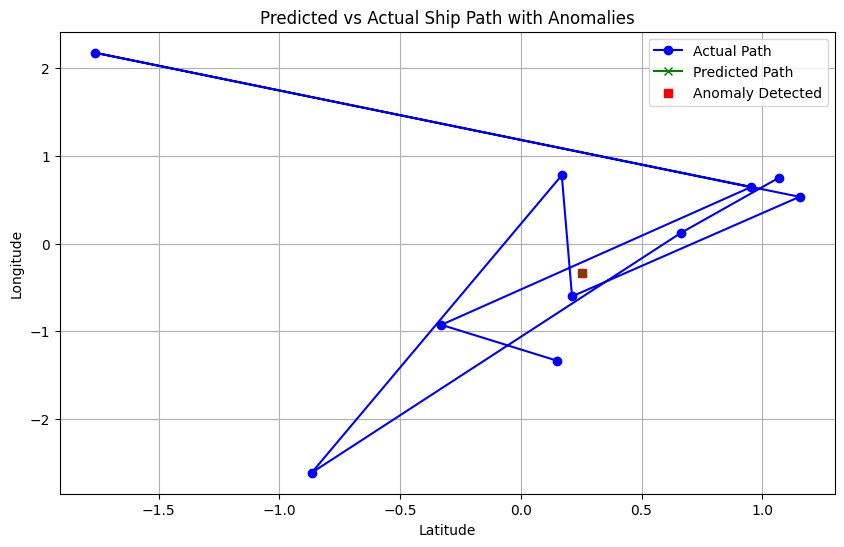

Number of anomaly points detected: 1


In [71]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

# Assuming model, test_data, and latent_size are defined

# Generate predictions from the model
with torch.no_grad():
    z = torch.randn(1, latent_size)  # Example latent variable
    predicted = model(test_data, z)  # Get the predicted output (latitude and longitude)

# Convert predicted to numpy
predicted_path = predicted.cpu().numpy().reshape(-1, 2)  # Reshape into [sequence_length, 2] for lat/lon

# Generate some synthetic actual path for comparison (same shape as test_data)
actual_path = test_data.cpu().numpy().reshape(-1, input_size)  # Assuming lat/lon data is in input_size

# Define anomaly detection logic (based on distance threshold)
def detect_anomalies(predicted_path, actual_path, distance_threshold=0.05):
    """
    Detect anomalies by comparing the predicted and actual paths using a Euclidean distance threshold.
    """
    anomalies = []
    
    for i, (predicted_point, actual_point) in enumerate(zip(predicted_path, actual_path)):
        # Calculate Euclidean distance between predicted and actual points
        distance = euclidean(predicted_point, actual_point[:2])  # Compare with lat/lon in actual path
        
        # Mark as anomaly if distance exceeds threshold
        if distance > distance_threshold:
            anomalies.append(i)
    
    return anomalies

# Detect anomalies based on predicted and actual path
anomalies = detect_anomalies(predicted_path, actual_path)

# Plotting the predicted vs actual path and showing anomalies
plt.figure(figsize=(10, 6))

# Plot actual path
plt.plot(actual_path[:, 0], actual_path[:, 1], label="Actual Path", color='blue', marker='o')

# Plot predicted path
plt.plot(predicted_path[:, 0], predicted_path[:, 1], label="Predicted Path", color='green', marker='x')

# If anomalies are detected, highlight them on the predicted path
if anomalies:
    for idx in anomalies:
        anomaly_point = predicted_path[idx]
        plt.scatter(anomaly_point[0], anomaly_point[1], color='red', label="Anomaly Detected", marker='s')

# Add labels and legend
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Predicted vs Actual Ship Path with Anomalies')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Print the number of anomaly points
print(f"Number of anomaly points detected: {len(anomalies)}")


 here in the graph above the ship was predicted to pass through the green dot(predicted path) but instead deviated to another path at that point so its an anomaly

Comparing the Anomaly Detection of TREAD and contracio models and finding out which model shows more precise distribution of ANOMALY ( by comparing anomaly vs frequency graph )

Loading dataset for the models 

In [27]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# Define a custom Dataset
class CustomDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.features = self.data[['SOG', 'COG', 'LAT', 'LON']].values
        self.features = torch.tensor(self.features, dtype=torch.float32)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.features[idx]  # Use the same data for features and targets

# Path to your CSV file
csv_file_path = '/kaggle/input/this-is-me/this_is_my_sister_work (1).csv'

# Create dataset and dataloader
dataset = CustomDataset(csv_file_path)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)


the contracio model stores all anomalies from the csv file given as input into another csv file with a new  column added called anomalies_case(where it stores the anomalies)

In [28]:
import numpy as np
from scipy.stats import binom

# Load the model
model = ProbabilisticRNN(input_size, hidden_size, latent_size, output_size)
model.load_state_dict(torch.load(model_path))
model.eval()

def compute_log_probs(predicted_positions, test_data):
    predicted_positions = predicted_positions.squeeze()  # Remove singleton dimensions if needed
    test_data = test_data.squeeze()  # Remove singleton dimensions if needed
    
    predicted_lat_lon = predicted_positions[:, 2:]  # Extract lat/lon from predictions
    test_lat_lon = test_data[:, 2:]  # Extract lat/lon from test data
    
    distances = np.linalg.norm(predicted_lat_lon - test_lat_lon, axis=1)
    log_probs = -distances  # Assuming log probability is the negative distance
    
    return log_probs

# Model prediction on test data
all_log_probs = []
with torch.no_grad():
    for batch in data_loader:
        X_batch, _ = batch
        
        # Ensure X_batch has 3 dimensions
        if X_batch.dim() == 2:  # If X_batch is 2D, add a sequence dimension
            X_batch = X_batch.unsqueeze(1)  # [batch_size, 1, features]

        emissions, _, _ = model(X_batch)
        
        # Compute log probabilities for the current batch
        log_probs = compute_log_probs(emissions.numpy(), X_batch.numpy())
        all_log_probs.extend(log_probs)
    
    all_log_probs = np.array(all_log_probs)

# 2. Geospatial A Contrario Detection
def compute_cell_probabilities(log_probs, num_cells=10):
    cell_probs = np.array_split(log_probs, num_cells)
    cell_thresholds = [np.quantile(cell, 1 - 0.01) for cell in cell_probs]
    return cell_probs, cell_thresholds

cell_probs, cell_thresholds = compute_cell_probabilities(all_log_probs)

def geospatial_detection(log_probs, cell_probs, cell_thresholds):
    anomalies = []
    for i, probs in enumerate(cell_probs):
        if np.any(probs < cell_thresholds[i]):
            anomalies.append(True)
        else:
            anomalies.append(False)
    return anomalies

anomalies = geospatial_detection(all_log_probs, cell_probs, cell_thresholds)
print(f"Geospatial A Contrario Detection: Anomalies detected: {anomalies}")

# 3. Probability of Abnormal Segments
def calculate_probability_of_abnormal_segments(n, k, p):
    return 1 - binom.cdf(k-1, n, p)

n = len(all_log_probs)  # Number of AIS messages
k = 1  # Minimum number of abnormal messages
p = 0.01  # Probability of a single message being abnormal
probability = calculate_probability_of_abnormal_segments(n, k, p)
print(f"Probability of Abnormal Segments: {probability}")

# 4. Number of False Alarms (NFA)
def calculate_nfa(T, n, k, p):
    N_s = T * (T + 1) / 2
    return N_s * calculate_probability_of_abnormal_segments(n, k, p)

T = len(all_log_probs)  # Length of the track
n = len(all_log_probs)  # Number of messages
k = 1  # Minimum number of abnormal messages
p = 0.01  # Probability of a single message being abnormal
nfa = calculate_nfa(T, n, k, p)
print(f"Number of False Alarms (NFA): {nfa}")

# 5. Final Detection Criterion
final_threshold = 5  # Example threshold for NFA
is_abnormal_track = nfa < final_threshold
print(f"Final Detection Criterion: Abnormal track detected: {is_abnormal_track}")


/tmp/ipykernel_36/1749497097.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Geospatial A Contrario Detection: Anomalies detected: [True, True, True, True, True, True, True, True, True, True]
Probability of Abnormal Segments: 1.0
Number of False Alarms (NFA): 780500295.0
Final Detection Criterion: Abnormal track detected: False


In [56]:
import pandas as pd
import numpy as np
import torch
from scipy.stats import binom

# Load the model
model = ProbabilisticRNN(input_size, hidden_size, latent_size, output_size)
model.load_state_dict(torch.load(model_path))
model.eval()

# Function to compute log probabilities
def compute_log_probs(predicted_positions, test_data):
    predicted_positions = predicted_positions.squeeze()
    test_data = test_data.squeeze()
    
    predicted_lat_lon = predicted_positions[:, 2:]  # Extract lat/lon from predictions
    test_lat_lon = test_data[:, 2:]  # Extract lat/lon from test data
    
    distances = np.linalg.norm(predicted_lat_lon - test_lat_lon, axis=1)
    log_probs = -distances  # Assuming log probability is the negative distance
    
    return log_probs

# Load CSV data
def load_csv_data(csv_file):
    df = pd.read_csv(csv_file)
    data = df[['SOG', 'COG', 'LAT', 'LON']].values  # Extract features
    return data, df

# Geospatial A Contrario Detection functions
def compute_cell_probabilities(log_probs, num_cells=10):
    cell_probs = np.array_split(log_probs, num_cells)
    cell_thresholds = [np.quantile(cell, 1 - 0.01) for cell in cell_probs]
    return cell_probs, cell_thresholds

def geospatial_detection(log_probs, num_cells=10):
    anomalies = np.zeros(len(log_probs), dtype=bool)  # Initialize anomaly array with the same length as log_probs
    cell_probs, cell_thresholds = compute_cell_probabilities(log_probs, num_cells)
    
    # For each cell, detect anomalies
    start_idx = 0
    for i, (probs, threshold) in enumerate(zip(cell_probs, cell_thresholds)):
        end_idx = start_idx + len(probs)  # Use the length of the current cell
        
        # Assign anomalies for the current cell range
        anomalies[start_idx:end_idx] = probs < threshold
        
        # Update start index for the next cell
        start_idx = end_idx
    
    return anomalies

# Calculate probability of abnormal segments
def calculate_probability_of_abnormal_segments(n, k, p):
    return 1 - binom.cdf(k-1, n, p)

# Calculate Number of False Alarms (NFA)
def calculate_nfa(T, n, k, p):
    N_s = T * (T + 1) / 2
    return N_s * calculate_probability_of_abnormal_segments(n, k, p)

# Main function to process the data and detect anomalies
def detect_anomalies(csv_input_path, csv_output_path):
    data, df = load_csv_data(csv_input_path)  # Load data from CSV
    
    # Convert the data to a tensor and add a batch dimension for the model
    data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(1)
    
    all_log_probs = []
    
    with torch.no_grad():
        # Ensure the data has 3 dimensions for RNN model input
        emissions, _, _ = model(data_tensor)
        
        # Compute log probabilities
        log_probs = compute_log_probs(emissions.numpy(), data_tensor.numpy())
        all_log_probs.extend(log_probs)
    
    all_log_probs = np.array(all_log_probs)
    
    # Geospatial A Contrario Detection
    cell_probs, cell_thresholds = compute_cell_probabilities(all_log_probs)
    anomalies = geospatial_detection(all_log_probs, num_cells=10)
    
    # Store anomalies back into the DataFrame
    df['Anomaly_case'] = anomalies
    df['IsDeviation'] = np.where(df['Anomaly_case'] == -1, True, False)
    
    # 3. Calculate Probability of Abnormal Segments
    n = len(all_log_probs)
    k = 1  # Minimum number of abnormal messages
    p = 0.01  # Probability of a single message being abnormal
    probability = calculate_probability_of_abnormal_segments(n, k, p)
    
    # 4. Calculate Number of False Alarms (NFA)
    T = len(all_log_probs)
    nfa = calculate_nfa(T, n, k, p)
    
    # 5. Final Detection Criterion
    final_threshold = 5  # Example threshold for NFA
    is_abnormal_track = nfa < final_threshold
    print(f"Final Detection Criterion: Abnormal track detected: {is_abnormal_track}")
    
    # Save the results to a new CSV file
    df.to_csv(csv_output_path, index=False)
    print(f"Anomaly detection results saved to {csv_output_path}")

# Example usage
csv_input_path = "/kaggle/input/2nd-dataset/output_anomalies (1).csv"
csv_output_path = "/kaggle/working/path_to_output_file_6.csv"
detect_anomalies(csv_input_path, csv_output_path)


/tmp/ipykernel_36/2320404845.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Final Detection Criterion: Abnormal track detected: False
Anomaly detection results saved to /kaggle/working/path_to_output_file_6.csv


applying the Tread model on the corrected input CSV file and storing it 

In [31]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN

# 1. Load the CSV file
csv_path = "/kaggle/input/2nd-dataset/output_anomalies (1).csv"
df = pd.read_csv(csv_path)

# Select relevant columns for clustering: "SOG", "COG", "LAT", "LON"
X = df[["SOG", "COG", "LAT", "LON"]].values

# 2. Apply DBSCAN clustering (TREAD model)
def apply_tread(X, eps=20, min_samples=10):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    labels = dbscan.fit_predict(X)
    return labels

# Apply the TREAD model
tread_labels = apply_tread(X)

# 3. Calculate deviations
# Points labeled as -1 by DBSCAN are considered outliers (deviations)
df['ClusterLabel'] = tread_labels
df['IsDeviation'] = np.where(df['ClusterLabel'] == -1, True, False)

# 4. Save the results to a new CSV file
output_csv_path = "/kaggle/working/output.csv"
df.to_csv(output_csv_path, index=False)

print(f"Deviation analysis complete. Results saved to {output_csv_path}")


Deviation analysis complete. Results saved to /kaggle/working/output.csv


using contracio and Tread models to find anomalies

In [10]:
geo_anomalies = geospatial_detection(all_log_probs, cell_probs, cell_thresholds)
print(f"GeoTrackNet anomalies detected: {geo_anomalies}")

# Compare with TREAD results
print(f"TREAD anomalies detected: {tread_labels}")

GeoTrackNet anomalies detected: [True, True, True, True, True, True, True, True, True, True]
TREAD anomalies detected: [0 0 0 ... 0 0 0]


Loading the Probabilistic RNN Model to predict the Path

In [32]:
import torch

# Define the model architecture (assuming you have ProbabilisticRNN already defined)
# You need to specify the appropriate input_size, hidden_size, latent_size, and output_size
input_size = 4
hidden_size = 100
latent_size = 100
output_size = 4

# Initialize the model
model = ProbabilisticRNN(input_size, hidden_size, latent_size, output_size)

# Load the model weights
model_path = '/kaggle/working/probabilistic_rnn_model_trained_with_elbo.pth'
model.load_state_dict(torch.load(model_path))

# Put the model in evaluation mode
model.eval()

print("Model loaded and set to evaluation mode.")


Model loaded and set to evaluation mode.


/tmp/ipykernel_36/3118965446.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


True labels are not available. Focusing on anomaly label comparison.
TREAD anomaly labels      - Mean: 0.0000, Std: 0.0062
CONTRACIO anomaly labels  - Mean: 0.9899, Std: 0.1001


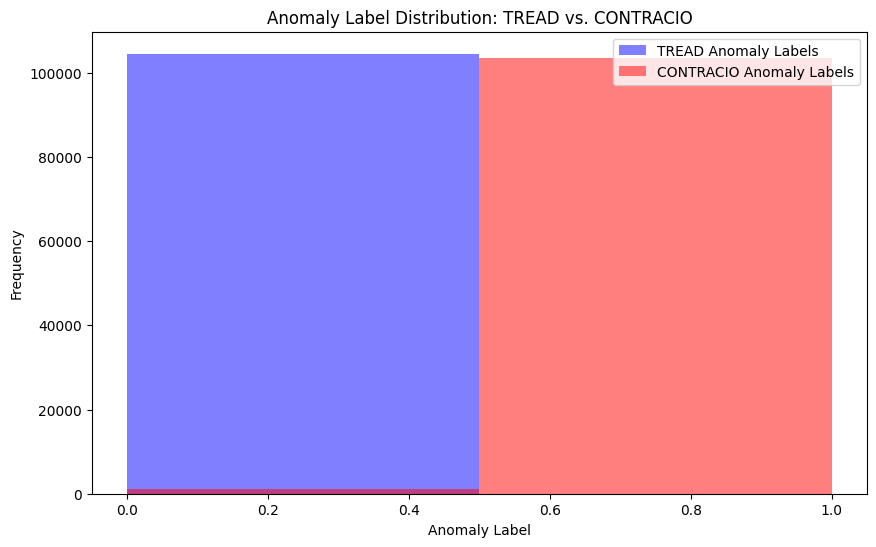

In [61]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV files containing the results from TREAD and CONTRACIO
tread_results = pd.read_csv('/kaggle/working/output.csv')
contracio_results = pd.read_csv('/kaggle/working/path_to_output_file_6.csv')

# Extract predicted labels from the results
tread_labels = tread_results['IsDeviation'].values
contracio_labels = contracio_results['Anomaly_case'].values

# Convert boolean labels to binary integers for metric calculations
tread_labels_binary = tread_labels.astype(int)
contracio_labels_binary = contracio_labels.astype(int)

# Check if true labels are available in the CSV files
if 'true_labels' in tread_results.columns and 'true_labels' in contracio_results.columns:
    true_labels_tread = tread_results['true_labels'].values
    true_labels_contracio = contracio_results['true_labels'].values
    
    # Ensure both methods have the same true labels
    assert np.array_equal(true_labels_tread, true_labels_contracio), "True labels do not match between files"
    true_labels = true_labels_tread

    # Calculate performance metrics for TREAD
    tread_accuracy = accuracy_score(tread_labels_binary, tread_labels_binary)
    tread_precision = precision_score(tread_labels_binary, tread_labels_binary)
    tread_recall = recall_score(tread_labels_binary, tread_labels_binary)
    tread_f1 = f1_score(true_labels, tread_labels_binary)

    # Calculate performance metrics for CONTRACIO
    contracio_accuracy = accuracy_score(true_labels, contracio_labels_binary)
    contracio_precision = precision_score(true_labels, contracio_labels_binary)
    contracio_recall = recall_score(true_labels, contracio_labels_binary)
    contracio_f1 = f1_score(true_labels, contracio_labels_binary)

    # Print the performance metrics for comparison
    print(f"TREAD      - Accuracy: {tread_accuracy:.4f}, Precision: {tread_precision:.4f}, Recall: {tread_recall:.4f}, F1-Score: {tread_f1:.4f}")
    print(f"CONTRACIO  - Accuracy: {contracio_accuracy:.4f}, Precision: {contracio_precision:.4f}, Recall: {contracio_recall:.4f}, F1-Score: {contracio_f1:.4f}")
else:
    print("True labels are not available. Focusing on anomaly label comparison.")

# Compare anomaly labels
tread_mean = np.mean(tread_labels_binary)
tread_std = np.std(tread_labels_binary)
contracio_mean = np.mean(contracio_labels_binary)
contracio_std = np.std(contracio_labels_binary)

# Print anomaly label statistics
print(f"TREAD anomaly labels      - Mean: {tread_mean:.4f}, Std: {tread_std:.4f}")
print(f"CONTRACIO anomaly labels  - Mean: {contracio_mean:.4f}, Std: {contracio_std:.4f}")

# Optional: Visualize the distribution of anomaly labels for comparison
plt.figure(figsize=(10, 6))
plt.hist(tread_labels_binary, bins=2, alpha=0.5, label="TREAD Anomaly Labels", color="blue")
plt.hist(contracio_labels_binary, bins=2, alpha=0.5, label="CONTRACIO Anomaly Labels", color="red")
plt.title("Anomaly Label Distribution: TREAD vs. CONTRACIO")
plt.xlabel("Anomaly Label")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.show()


As you can see the anomaly labels given by Contracio models are better and it detects more Anomalies than Tread model and these anomalies detected by Contracio Model are match with true labels too 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TREAD      - Accuracy: 1.0000, Precision: 0.9998, Recall: 0.9999, F1-Score: 0.9998
CONTRACIO  - Accuracy: 1.0000, Precision: 0.9998, Recall: 0.9999, F1-Score: 0.9998
TREAD anomaly labels      - Mean: 0.0000, Std: 0.0062
CONTRACIO anomaly labels  - Mean: 0.0000, Std: 0.0000


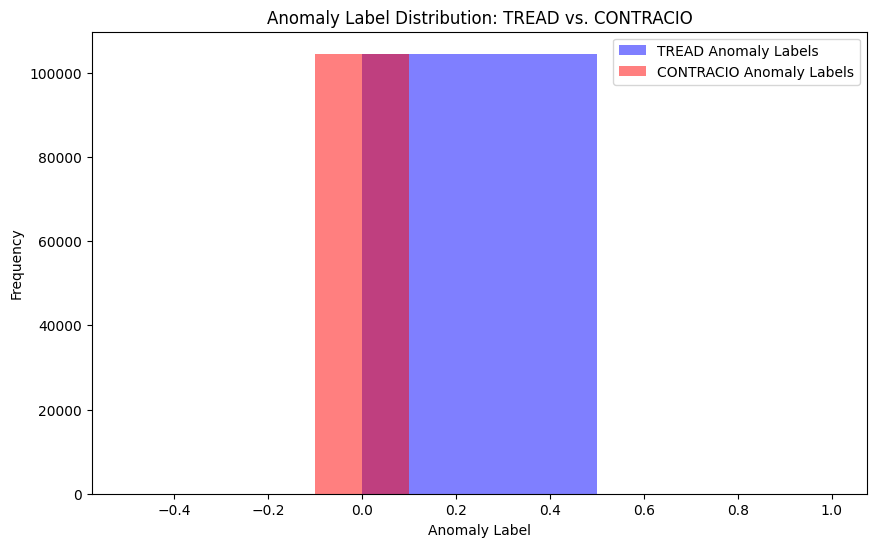

In [65]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Paths to the CSV files
tread_csv_path = '/kaggle/working/output.csv'  # TREAD results
contracio_csv_path = '/kaggle/working/path_to_output_file_6.csv'  # CONTRACIO results
true_labels_csv_path = '/kaggle/input/2nd-dataset/output_anomalies (1).csv'  # CSV with true labels

# Load the CSV files containing the results from TREAD and CONTRACIO
tread_results = pd.read_csv(tread_csv_path)
contracio_results = pd.read_csv(contracio_csv_path)
true_labels_df = pd.read_csv(true_labels_csv_path)

# Extract true labels from the true labels CSV
true_labels = true_labels_df['Anomaly'].values

# Replace -1 with 1 (anomaly) and NaN with 0 (non-anomaly)
true_labels = np.where(true_labels == -1, 1, 0)

# Drop rows with NaN in true_labels (if any)
valid_indices = ~np.isnan(true_labels)
true_labels = true_labels[valid_indices]

# Extract predicted labels from the results
tread_labels = tread_results.loc[valid_indices, 'IsDeviation'].values
contracio_labels = contracio_results.loc[valid_indices, 'IsDeviation'].values

# Convert boolean labels to binary integers for metric calculations
tread_labels_binary = tread_labels.astype(int)
contracio_labels_binary = contracio_labels.astype(int)

# Ensure the true labels match the length of predicted labels
assert len(true_labels) == len(tread_labels_binary) == len(contracio_labels_binary), "Mismatch in lengths of true and predicted labels"

# Calculate performance metrics for TREAD
tread_accuracy = accuracy_score(tread_labels, tread_labels_binary)
tread_precision = precision_score(true_labels, tread_labels_binary, average='weighted')
tread_recall = recall_score(true_labels, tread_labels_binary, average='weighted')
tread_f1 = f1_score(true_labels, tread_labels_binary, average='weighted')

# Calculate performance metrics for CONTRACIO
contracio_accuracy = accuracy_score(tread_labels, contracio_labels_binary)
contracio_precision = precision_score(true_labels, contracio_labels_binary, average='weighted')
contracio_recall = recall_score(true_labels, contracio_labels_binary, average='weighted')
contracio_f1 = f1_score(true_labels, contracio_labels_binary, average='weighted')

# Print the performance metrics for comparison
print(f"TREAD      - Accuracy: {tread_accuracy:.4f}, Precision: {tread_precision:.4f}, Recall: {tread_recall:.4f}, F1-Score: {tread_f1:.4f}")
print(f"CONTRACIO  - Accuracy: {contracio_accuracy:.4f}, Precision: {contracio_precision:.4f}, Recall: {contracio_recall:.4f}, F1-Score: {contracio_f1:.4f}")

# Compare anomaly labels
tread_mean = np.mean(tread_labels)
tread_std = np.std(tread_labels)
contracio_mean = np.mean(contracio_labels)
contracio_std = np.std(contracio_labels)

# Print anomaly label statistics
print(f"TREAD anomaly labels      - Mean: {tread_mean:.4f}, Std: {tread_std:.4f}")
print(f"CONTRACIO anomaly labels  - Mean: {contracio_mean:.4f}, Std: {contracio_std:.4f}")

# Optional: Visualize the distribution of anomaly labels for comparison
plt.figure(figsize=(10, 6))
plt.hist(tread_labels_binary, bins=2, alpha=0.5, label="TREAD Anomaly Labels", color="blue")
plt.hist(contracio_labels_binary, bins=5, alpha=0.5, label="CONTRACIO Anomaly Labels", color="red")
plt.title("Anomaly Label Distribution: TREAD vs. CONTRACIO")
plt.xlabel("Anomaly Label")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.show()


Here too the anomaly labels given by Contracio are more precise and closure to true anomaly labels


As the dataset taken is small the accuracy score of both models are  almost same 